In [1]:
import os

gpus = [3]
os.environ['CUDA_VISIBLE_DEVICES']=','.join([str(i) for i in gpus])

In [2]:
import tensorflow as tf 
import tensorflow.keras as keras
import numpy as np 
from oe_acute import MNE
import pickle
import sys
import random
#from AE import MDSAE as ae
from network_visualisation import plot_these_aud_weights
import network_visualisation
import quantify_aud_strfs
import matplotlib.pyplot as plt

In [3]:
bird = 'B1240'
d = 32

In [4]:
segs_path = '/mnt/cube/srrudrar/stim_preprocess/temporal_model/{}/segs_list_32.pkl'.format(bird, bird)     ###change
next_path = '/mnt/cube/srrudrar/stim_preprocess/temporal_model/{}/next_list_32.pkl'.format(bird, bird)            ###change

In [5]:
def extract_spec_data(x_path, y_path, random_seed=None, global_normalize=False):

    all_curr=np.load(x_path,allow_pickle=True)
    all_next=np.load(y_path,allow_pickle=True)

    x_array = all_curr
    y_array = all_next

    if random_seed is None:
        rand_idx=np.arange(0, np.shape(x_array)[0])
    else:
        np.random.seed(random_seed)
        rand_idx=np.random.choice(range(np.shape(x_array)[0]), size=np.shape(x_array)[0],replace=False)
    
    split_train_idx, split_val_idx = rand_idx[np.shape(x_array)[0]//10:],rand_idx[:np.shape(x_array)[0]//10] 
    x_train, x_val=np.asarray(x_array)[split_train_idx], np.asarray(x_array)[split_val_idx]
    y_train, y_val=np.asarray(y_array)[split_train_idx],np.asarray(y_array)[split_val_idx]
    
    #if global_normalize:
    #    x_train=x_train/x_train.max()
    #    y_train=y_train/y_train.max()
    #    x_val=x_val/x_val.max()
    #    y_val=y_val/y_val.max()
    return x_train,y_train,x_val,y_val

In [6]:
x_train1,y_train1,x_val1,y_val1 = extract_spec_data(segs_path, next_path, random_seed=0,global_normalize=True)

In [7]:
x_train0 = x_train1[:, :32, :]
x_val0 = x_val1[:, :32, :]
y_train0 = y_train1[:, :32]
y_val0 = y_val1[:, :32]

In [8]:
###pairwise averaging

In [9]:
def kozlov_averaging(spec, n_rows, n_cols):
    '''
    Average rows and columns of spectrogram according to Kozlov & Gentner 2016 
    In Andrei's paper he averaged twice along rows(frequency bins) and three times
    across columns (time bins).

    n_rows specifies how many times to average rows pairwise, and n_cols specifies how many times
    to average columsn pairwise.
    '''
    spec_c = np.copy(spec)

    for idx in range(n_rows):
        spec_c = MNE.avg_pairwise(spec_c, axis=0)

    for idx in range(n_cols):
        spec_c = MNE.avg_pairwise(spec_c, axis=1)

    return spec_c

In [10]:
x_train_avg = np.asarray([kozlov_averaging(s, n_rows=2, n_cols=3) for s in x_train0])
x_val_avg = np.asarray([kozlov_averaging(s, n_rows=2, n_cols=3) for s in x_val0])

In [11]:
np.shape(x_train_avg), np.shape(x_val_avg)

((51357, 8, 4), (5706, 8, 4))

In [12]:
x_train = np.asarray([s.flatten() for s in x_train_avg])
x_val = np.asarray([s.flatten() for s in x_val_avg])

In [13]:
np.shape(x_train), np.shape(x_val)

((51357, 32), (5706, 32))

In [14]:
from sklearn.decomposition import PCA
pca = PCA(n_components = d)

In [15]:
pca.fit(x_train)

PCA(copy=True, iterated_power='auto', n_components=32, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [16]:
enc_train = pca.transform(x_train)

In [17]:
enc_test = pca.transform(x_val)

In [18]:
np.shape(enc_test)

(5706, 32)

In [19]:
rec_train0 = pca.inverse_transform(enc_train[0])

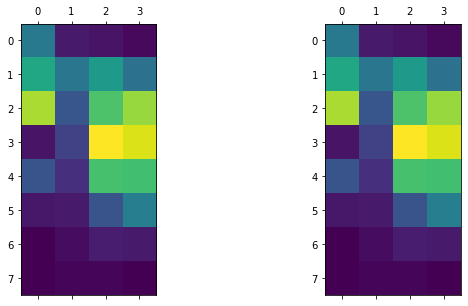

In [20]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5))
axs[0].matshow(x_train[0].reshape((8,4)))
axs[1].matshow(rec_train0.reshape((8,4)))

In [21]:
resp_train = x_train1[:, 32:, :]
resp_test = x_val1[:, 32:, :]

In [22]:
np.save('/mnt/cube/srrudrar/pca_model/{}/32x32/stim_resp_32x32_{}/enc_test_{}_avg1.npy'.format(bird,d,d), enc_test)
np.save('/mnt/cube/srrudrar/pca_model/{}/32x32/stim_resp_32x32_{}/resp_test_{}_avg1.npy'.format(bird,d,d), resp_test)